In [ ]:
# this is a copy of tutorial 3 at the start
# but instead of faking it by dragging the car through waypoints
# we will be giving the car simple inputs to guide it along the route

In [1]:
#all imports
import carla #the sim library itself
import time # to set a delay after each photo
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import math
import sys

In [2]:
# connect to the sim 
client = carla.Client('localhost', 2000)

In [3]:
#define environment/world and get possible places to spawn a car
# start a car
world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
#look for a blueprint of Mini car
vehicle_bp = world.get_blueprint_library().filter('*mini*')

start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
#setting RGB Camera - this follow the approach explained in a Carla video
# link: https://www.youtube.com/watch?v=om8klsBj4rc&t=1184s

#camera mount offset on the car - you can tweak these to have the car in view or not
CAMERA_POS_Z = 3 
CAMERA_POS_X = -5 

camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '360')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()

camera_data = {'image': np.zeros((image_h,image_w,4))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))

In [4]:
''' 
This is the new Bit for tutorial 4
First we need to create controls functions so we could
push the car along the route
'''
# define speed contstants
PREFERRED_SPEED = 30 # what it says
SPEED_THRESHOLD = 2 #defines when we get close to desired speed so we drop the

#adding params to display text to image
font = cv2.FONT_HERSHEY_SIMPLEX
# org - defining lines to display telemetry values on the screen
org = (30, 30) # this line will be used to show current speed
org2 = (30, 50) # this line will be used for future steering angle
org3 = (30, 70) # and another line for future telemetry outputs
org4 = (30, 90) # and another line for future telemetry outputs
org3 = (30, 110) # and another line for future telemetry outputs
fontScale = 0.5
# white color
color = (255, 255, 255)
# Line thickness of 2 px
thickness = 1

def maintain_speed(s):
    ''' 
    this is a very simple function to maintan desired speed
    s arg is actual current speed
    '''
    if s >= PREFERRED_SPEED:
        return 0
    elif s < PREFERRED_SPEED - SPEED_THRESHOLD:
        return 0.8 # think of it as % of "full gas"
    else:
        return 0.4 # tweak this if the car is way over or under preferred speed 


In [5]:
# now little demo to drive straight
# close to a desired speed

# - press Q to exit, you need to run the bit above to start the car

cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
cv2.imshow('RGB Camera',camera_data['image'])

#main loop 
quit = False

while True:
    # Carla Tick
    world.tick()
    if cv2.waitKey(1) == ord('q'):
        quit = True
        break
    image = camera_data['image']
    
    steering_angle = 0 # we do not have it yet
    # to get speed we need to use 'get velocity' function
    v = vehicle.get_velocity()
    # if velocity is a vector in 3d
    # then speed is like hypothenuse in a right triangle
    # and 3.6 is a conversion factor from meters per second to kmh
    # e.g. kmh is 1000 meters and one hour is 60 min with 60 sec = 3600 sec
    speed = round(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2),0)
    # now we add the speed to the window showing a camera mounted on the car

    vehicle_pos = vehicle.get_transform()
    image = cv2.putText(image, 'Speed: '+str(int(speed))+' kmh' + 'Position: '+ str(vehicle_pos.location) , org2, 
                        font, fontScale, color, thickness, cv2.LINE_AA)
    # this is where we used the function above to determine accelerator input
    # from current speed
    estimated_throttle = maintain_speed(speed)
    # now we apply accelerator
    vehicle.apply_control(carla.VehicleControl(throttle=estimated_throttle, 
                                               steer=steering_angle))
    cv2.imshow('RGB Camera',image)

#clean up
cv2.destroyAllWindows()
camera.stop()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

In [6]:
# route planning bit like shown in Tutorial 3
sys.path.append('E:/UADY/CARLA/CARLA_Latest/WindowsNoEditor/PythonAPI/carla') # tweak to where you put carla
from agents.navigation.global_route_planner import GlobalRoutePlanner

point_a = start_point.location #we start at where the car is

sampling_resolution = 1
grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)

# now let' pick the longest possible route
distance = 0
for loc in spawn_points: # we start trying all spawn points 
                            #but we just exclude first at zero index
    cur_route = grp.trace_route(point_a, loc.location)
    if len(cur_route)>distance:
        distance = len(cur_route)
        route = cur_route
#draw the route in sim window - Note it does not get into the camera of the car
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)

In [8]:

#no pincha
# to figure out how to steer, we need to show in the camera view what telemetry is available
# and how it changes when the car is driving in autopilot

# we show speed as in Tutorial 4 but we are adding results of of get_forward_vector() function
# so we can see how x and y change as the car driver around and pint in different directions

# - press Q to exit, you need to run the bit above to start the car
# - do not forget to run car spawning bit above each time before this

cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
cv2.imshow('RGB Camera',camera_data['image'])

vehicle.set_autopilot(True)

#main loop 
quit = False

while True:
    # Carla Tick
    world.tick()
    if cv2.waitKey(1) == ord('q'):
        vehicle.set_autopilot(False)
        vehicle.apply_control(carla.VehicleControl(throttle=0, 
                                                   steer=0,
                                                  brake=1))
        quit = True
        break
    image = camera_data['image']
    
    #get current speed
    v = vehicle.get_velocity()
    speed = round(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2),0)
    # now we add the speed to the window showing a camera mounted on the car
    image = cv2.putText(image, 'Speed: '+str(int(speed))+' kmh', org2, 
                        font, fontScale, color, thickness, cv2.LINE_AA)

    # show forward vector values (z dimension is ignored as we are not navigating up or down)
    fwd_vector = vehicle.get_transform().get_forward_vector()
    # now we overlay x and y
    image = cv2.putText(image, 'Fwd_vec.x: '+str(round(fwd_vector.x,3)), org3, 
                        font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Fwd_vec.y: '+str(round(fwd_vector.y,3)), org4, 
                        font, fontScale, color, thickness, cv2.LINE_AA)

    cv2.imshow('RGB Camera',image)

#clean up
cv2.destroyAllWindows()
camera.stop()

for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

SyntaxError: invalid syntax (2738925301.py, line 1)

What we have learned above:
    The forward vector returns 3 values: x, y and z
    We are interested in x and y,
    where x is kind of like the car angle in relation to X axis from -1 to +1
    and y is the same against y axis
    
Examples:
    car pointing at spawning point - facing the "library" (let's call it East) y=0, x=1
    car pointing North y=-1, x=0
    south: y=1, x=0
    west: y=0, x=-1
    
From here we need to use those against the direction towards the next navigation waypoint

In [9]:
# now let's figure out direction to next waypoint

# For that we need to visualise it and get its coordinates
# show car spawn point and first few waypoints in spectator view
# and we put waypoint's number as a symbol so we could try figure out angles against specific ones
world.debug.draw_string(route[25][0].transform.location, '25', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)
world.debug.draw_string(route[50][0].transform.location, '50', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)
world.debug.draw_string(route[75][0].transform.location, '75', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)
world.debug.draw_string(route[95][0].transform.location, '95', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)
world.debug.draw_string(route[120][0].transform.location, '120', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)
world.debug.draw_string(route[150][0].transform.location, '150', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)

world.debug.draw_string(route[175][0].transform.location, '175', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)
world.debug.draw_string(route[200][0].transform.location, '200', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)
world.debug.draw_string(route[225][0].transform.location, '225', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=600.0,
        persistent_lines=True)


# now we can see the car and the waypoints


In [10]:
# let's try waypoint 25
#then see what its vector is showing
# I picked wp 25 as it is the "last" one as the route completes left turn

wp_vector = route[25][0].transform.get_forward_vector()

# and let's also get coordinates of the car and the waypoint 25
car_x = vehicle.get_transform().location.x
car_y = vehicle.get_transform().location.y

wp_x = route[25][0].transform.location.x
wp_y = route[25][0].transform.location.y

print('waypoint 25 forward vector.x: ',wp_vector.x)
print('waypoint 25 forward vector.y: ',wp_vector.y)
print('waypoint 25 location x: ',wp_x)
print('waypoint 25 location y: ',wp_y)
print('car location x: ',car_x)
print('car location y: ',car_y)


waypoint 25 forward vector.x:  0.10560674965381622
waypoint 25 forward vector.y:  -0.9944079518318176
waypoint 25 location x:  -45.3754997253418
waypoint 25 location y:  8.452923774719238
car location x:  0.0
car location y:  0.0


The result shows the vector of WP 25 points nearly "North", i.e. straight Up as y=0.99 and obviously 
it has nothing to do where the cars is, it is just about the route and it shows where the route "heads" next

Which means we have to use coordinates of the car vs. coordinates of the next waypoint

So the direction or angle between two points (car and waypoint) can be defined as:

Difference in x = (wp_x - car_x) = -45.38 -(-64.64) = 19.26 meaning the waypoint is 19.26m forward
Difference in y = (wp_y - car_y) = 8.45 - 24.47 = -16.02 meaning the waypoint is 16m left

So you can see we need to take just under 45 degree angle to the left to face the waypoint straight


In [11]:
# calculate angle in degrees 
# remember this is the angle of straight line connecting locations

angle = math.degrees(math.atan((wp_y - car_y)/(wp_x - car_x))) 
print('angle to wp: ',angle)

# we will now need to get a difference fo car angle to that directional angle

NameError: name 'slope' is not defined

In [1]:
ruta_imagen = 'starting%20point-2.jpg'

# Muestra la imagen en un bloque de texto
display(Image(filename=ruta_imagen))

NameError: name 'Image' is not defined

In [12]:
# now let's test this when we get closer to point 95 at next intersection
# for that I let the car get there in autopilot and pressed Q so it stops

car_x = vehicle.get_transform().location.x
car_y = vehicle.get_transform().location.y

wp_x = route[95][0].transform.location.x
wp_y = route[95][0].transform.location.y

print('waypoint 95 location x: ',wp_x)
print('waypoint 95 location y: ',wp_y)
print('car location x: ',car_x)
print('car location y: ',car_y)

angle = math.degrees(math.atan((wp_y - car_y)/(wp_x - car_x))) 
print('angle to wp: ',angle)


#The resulting angle 78 is explained as

#delta y = -60 - (-40) = -20
#delta x = -49 - (-45) = -4

# What we learned here using 2 examples:
# The angle we get by doing dy/dx is always against the X axis 
# (no sh.t Sherlock we have dx in the denominator) 

waypoint 95 location x:  -49.300113677978516
waypoint 95 location y:  -59.576271057128906
car location x:  0.0
car location y:  0.0
angle to wp:  50.39181561982802


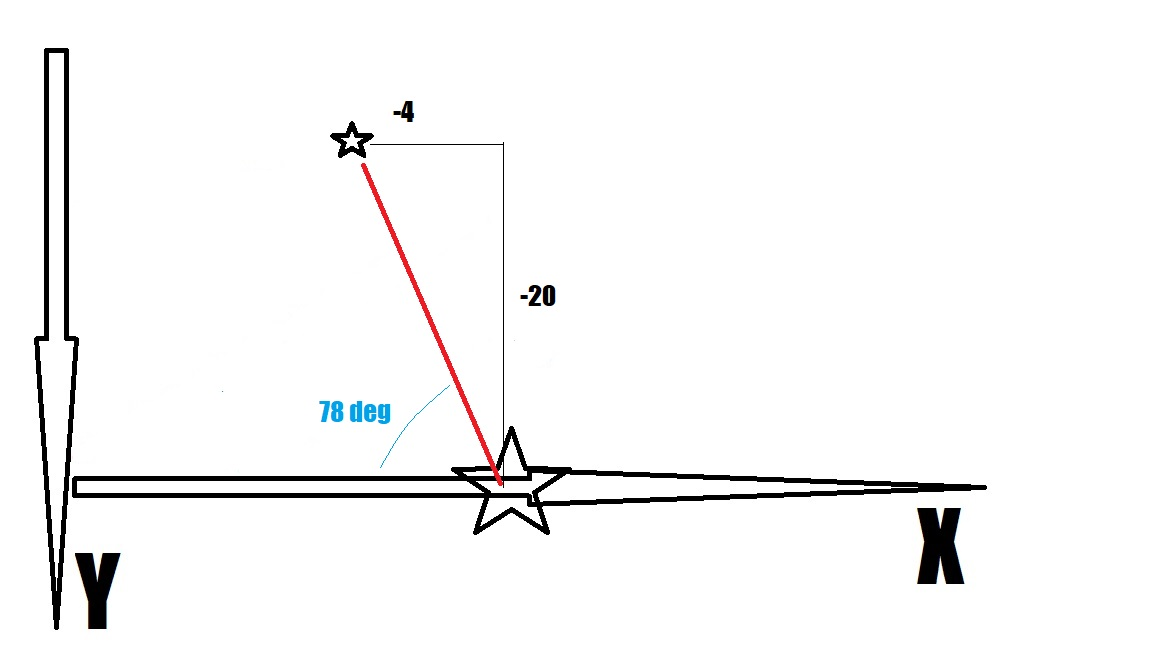

now we need to figure out how to convert the angle between the car and waypoint
into a vector in same format as car_forward_vector so we could get a difference between them

I used examples from the screen when the car was half way through a turn
to confirm that (vector_x squared) + (vector vector_y squared) = 1 (which is squared hypothenuse in right triangle)

so we need to convert our x_delta and y_delta into same vector format so we could compare two vectors and figure out steering input

dx**2 + dy**2 = N, where N is hyputhenuse
accordingly 1/sqrt(N) is a factor to scale down dx and dy
Example:
    
dx 19.26
dy -16.02

dx**2 + dy**2 is 627.588

square root is 25.05170653

scaled down dx 0.7688099004 (dx divided by..) which is vectorized x

scaled down dy -0.6394773938 (dy divide by ...) which is vectorized y

let's check it adds up

squared x (0.768.. **2) = 0.5910686629

squared y  =0.4089313371

yes they do add up to 1

So our formula to convert delta x and delta y to vectorised format is:

x = dx/((dx**2 + dy**2)**(1/2))

y = dy/((dx**2 + dy**2)**(1/2))

where **(1/2) is square root of 

In [13]:
# let's convert dx and dy to WP 25 into vector 
x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
print ('direction from car location to WP25 in vectorised format x, y:',x,y)

print('vehicle vector: ',vehicle.get_transform().get_forward_vector())

direction from car location to WP25 in vectorised format x, y: -0.6375340467325494 -0.7704221824797229
vehicle vector:  Vector3D(x=1.000000, y=0.000000, z=0.000000)


In [14]:
# now we have 2 vectors:
#1. Actual direction/angle of the car
#2. Direction to next waypoint
# So we need to get a difference between them so we can send that difference as an angle to steering

#I found this on stackoverflow:
#we will test it now
def angle_between(v1, v2):
    return math.degrees(np.arctan2(v1[1], v1[0]) - np.arctan2(v2[1], v2[0]))

In [15]:
#testing 
print('our angle to WP 25: ',angle_between((0.769,-0.639),(0.999,0.003)))  # this gets us our 39 degree angle to the left

print('our angle a mirror of WP 25 *if it was on the right: ',angle_between((0.769,0.639),(0.999,0.003))) 
# yes it is also 39 degrees right

#and some examples
print(angle_between((1, 0), (0, 1))) # between east and north
print(angle_between((1, 0), (1, 0))) # between same direction
print(angle_between((1, 0), (-1,0))) # between east and west


our angle to WP 25:  -39.896921411360864
our angle a mirror of WP 25 *if it was on the right:  39.552803649905094
-90.0
0.0
-180.0


In [16]:
# now we are ready to define steering calculation
def get_angle(car,wp):
    '''
    this function to find direction to selected waypoint
    '''
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    # vector to waypoint
    x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    
    #car vector
    car_vector = vehicle_pos.get_forward_vector()
    degrees = angle_between((x,y),(car_vector.x,car_vector.y))

    return degrees

In [17]:
# little test
get_angle(vehicle, route[125][0])

-141.04997360530598

In [18]:
# now we need to figure out what maximum steering angle is available:
# trun heels all the way left
vehicle.apply_control(carla.VehicleControl(throttle=0,steer=-1.0,brake=1))
#upon inspection the wheels turned left in an unrealistic 
# angle - looks like 75-80 degrees
# which means that max values -1 and + 1 correspond to say 75 degrees
# so we need to:
# 1. decide on a maximum angle we could apply - say 40 degrees
# 2. make a conversion "out of 75 degrees", e.g. if 75 is 1 then if we need 20 degrees, we need to use 20 / 75 = 0.26


In [19]:
#test steering function
world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
#look for a blueprint of Mini car
vehicle_bp = world.get_blueprint_library().filter('*mini*')

start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
#setting RGB Camera - this follow the approach explained in a Carla video
# link: https://www.youtube.com/watch?v=om8klsBj4rc&t=1184s

#camera mount offset on the car - you can tweak these to have the car in view or not
CAMERA_POS_Z = 3 
CAMERA_POS_X = -5 

camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '360')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()

camera_data = {'image': np.zeros((image_h,image_w,4))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))

cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
cv2.imshow('RGB Camera',camera_data['image'])

#main loop 
quit = False
curr_wp = 5 #we will be tracking waypoints in the route and switch to next one wen we get close to current one
predicted_angle = 0
while curr_wp<len(route)-1:
    # Carla Tick
    world.tick()
    if cv2.waitKey(1) == ord('q'):
        quit = True
        vehicle.apply_control(carla.VehicleControl(throttle=0,steer=0,brake=1))
        break
    image = camera_data['image']
    
    while curr_wp<len(route) and vehicle.get_transform().location.distance(route[curr_wp][0].transform.location)<5:
        curr_wp +=1 #move to next wp if we are too close
    
    predicted_angle = get_angle(vehicle,route[curr_wp][0])
    image = cv2.putText(image, 'Steering angle: '+str(round(predicted_angle,3)), org, font, fontScale, color, thickness, cv2.LINE_AA)
    v = vehicle.get_velocity()
    speed = round(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2),0)
    image = cv2.putText(image, 'Speed: '+str(int(speed)), org2, font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Next wp: '+str(curr_wp), org3, font, fontScale, color, thickness, cv2.LINE_AA)
    estimated_throttle = maintain_speed(speed)
    # extra checks on predicted angle when values close to 360 degrees are returned
    if predicted_angle<-300:
        predicted_angle = predicted_angle+360
    elif predicted_angle > 300:
        predicted_angle = predicted_angle -360
    steer_input = predicted_angle
    #and conversion of to -1 to +1
    if predicted_angle<-40:
        steer_input = -40
    elif predicted_angle>40:
        steer_input = 40
    # conversion from degrees to -1 to +1 input for apply control function
    steer_input = steer_input/75

    vehicle.apply_control(carla.VehicleControl(throttle=estimated_throttle, steer=steer_input))
    cv2.imshow('RGB Camera',image)
    

#clean up
cv2.destroyAllWindows()
camera.stop()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
vehicle.apply_control(carla.VehicleControl(throttle=0,steer=0,brake=1))

In [20]:
# clean after utility
cv2.destroyAllWindows()
camera.stop() # this is the opposite of camera.listen
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

In [21]:
#full code

#all imports
import carla #the sim library itself
import time # to set a delay after each photo
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import math
import sys
sys.path.append('C:/CARLA_0.9.14/PythonAPI/carla') # tweak to where you put carla
from agents.navigation.global_route_planner import GlobalRoutePlanner

# connect to the sim 
client = carla.Client('localhost', 2000)

# define speed contstants
PREFERRED_SPEED = 90 # what it says
SPEED_THRESHOLD = 2 #defines when we get close to desired speed so we drop the

# Max steering angle
MAX_STEER_DEGREES = 40

#camera mount offset on the car - you can tweak these to have the car in view or not
CAMERA_POS_Z = 3 
CAMERA_POS_X = -5 

#adding params to display text to image
font = cv2.FONT_HERSHEY_SIMPLEX
# org - defining lines to display telemetry values on the screen
org = (30, 30) # this line will be used to show current speed
org2 = (30, 50) # this line will be used for future steering angle
org3 = (30, 70) # and another line for future telemetry outputs
org4 = (30, 90) # and another line for future telemetry outputs
org3 = (30, 110) # and another line for future telemetry outputs
fontScale = 0.5
# white color
color = (255, 255, 255)
# Line thickness of 2 px
thickness = 1


# maintain speed function
def maintain_speed(s):
    ''' 
    this is a very simple function to maintan desired speed
    s arg is actual current speed
    '''
    if s >= PREFERRED_SPEED:
        return 0
    elif s < PREFERRED_SPEED - SPEED_THRESHOLD:
        return 0.9 # think of it as % of "full gas"
    else:
        return 0.4 # tweak this if the car is way over or under preferred speed 

#function to subtract 2 vectors
def angle_between(v1, v2):
    return math.degrees(np.arctan2(v1[1], v1[0]) - np.arctan2(v2[1], v2[0]))

# function to get angle between the car and target waypoint
def get_angle(car,wp):
    '''
    this function to find direction to selected waypoint
    '''
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    # vector to waypoint
    x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    
    #car vector
    car_vector = vehicle_pos.get_forward_vector()
    degrees = angle_between((x,y),(car_vector.x,car_vector.y))

    return degrees

world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
#look for a blueprint of Mini car
vehicle_bp = world.get_blueprint_library().filter('*mini*')

start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

# create and show the navigation route like in Tutorial 3
point_a = start_point.location #we start at where the car is
sampling_resolution = 1
grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
# now let' pick the longest possible route
distance = 0
for loc in spawn_points: # we start trying all spawn points 
                            #but we just exclude first at zero index
    cur_route = grp.trace_route(point_a, loc.location)
    if len(cur_route)>distance:
        distance = len(cur_route)
        route = cur_route
#draw the route in sim window - Note it does not get into the camera of the car
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=30.0,
        persistent_lines=True)


#setting RGB Camera - this follow the approach explained in a Carla video
# link: https://www.youtube.com/watch?v=om8klsBj4rc&t=1184s

camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '360')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()

camera_data = {'image': np.zeros((image_h,image_w,4))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))

cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
cv2.imshow('RGB Camera',camera_data['image'])

#main loop 
quit = False
curr_wp = 5 #we will be tracking waypoints in the route and switch to next one wen we get close to current one
predicted_angle = 0
while curr_wp<len(route)-1:
    # Carla Tick
    world.tick()
    if cv2.waitKey(1) == ord('q'):
        quit = True
        vehicle.apply_control(carla.VehicleControl(throttle=0,steer=0,brake=1))
        break
    image = camera_data['image']
    
    while curr_wp<len(route) and vehicle.get_transform().location.distance(route[curr_wp][0].transform.location)<5:
        curr_wp +=1 #move to next wp if we are too close
    
    predicted_angle = get_angle(vehicle,route[curr_wp][0])
    image = cv2.putText(image, 'Steering angle: '+str(round(predicted_angle,3)), org, font, fontScale, color, thickness, cv2.LINE_AA)
    v = vehicle.get_velocity()
    speed = round(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2),0)
    image = cv2.putText(image, 'Speed: '+str(int(speed)), org2, font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Next wp: '+str(curr_wp), org3, font, fontScale, color, thickness, cv2.LINE_AA)
    estimated_throttle = maintain_speed(speed)
    # extra checks on predicted angle when values close to 360 degrees are returned
    if predicted_angle<-300:
        predicted_angle = predicted_angle+360
    elif predicted_angle > 300:
        predicted_angle = predicted_angle -360
    steer_input = predicted_angle
    # limit steering to max angel, say 40 degrees
    if predicted_angle<-MAX_STEER_DEGREES:
        steer_input = -MAX_STEER_DEGREES
    elif predicted_angle>MAX_STEER_DEGREES:
        steer_input = MAX_STEER_DEGREES
    # conversion from degrees to -1 to +1 input for apply control function
    steer_input = steer_input/75

    vehicle.apply_control(carla.VehicleControl(throttle=estimated_throttle, steer=steer_input))
    cv2.imshow('RGB Camera',image)
    

#clean up
cv2.destroyAllWindows()
camera.stop()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

In [24]:
# visualise all spawn points in spectator view
# so we could pick some deliberately

# create and show the navigation route like in Tutorial 3
point_a = start_point.location #we start at where the car is
sampling_resolution = 1
grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
# now let' pick the longest possible route
distance = 0
point_id = 0
for loc in spawn_points: # we start trying all spawn points 
                            #but we just exclude first at zero index

    world.debug.draw_string(loc.location, str(point_id), draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=60.0,
        persistent_lines=True)
    point_id += 1
       

In [25]:
# let's start a fire truck @ point 116 
#so it could drive straight and knock our hero car off the navigation route
firetruck_bp = world.get_blueprint_library().filter('*fire*')

firetruck_start_point = spawn_points[116]
firetruck = world.try_spawn_actor(firetruck_bp[0], firetruck_start_point)

firetruck.apply_control(carla.VehicleControl(throttle=0.2, 
                                               steer=0))


In [30]:
#full code with firetruck intrusion ;)

#all imports
import carla #the sim library itself
import time # to set a delay after each photo
import numpy as np #in this example to change image representation - re-shaping
import math
import sys
sys.path.append('C:/CARLA_0.9.14/PythonAPI/carla') # tweak to where you put carla
from agents.navigation.global_route_planner import GlobalRoutePlanner

# connect to the sim 
client = carla.Client('localhost', 2000)

# define speed contstants
PREFERRED_SPEED = 40 # what it says
SPEED_THRESHOLD = 2 #defines when we get close to desired speed so we drop the

# Max steering angle
MAX_STEER_DEGREES = 40

#camera mount offset on the car - you can tweak these to have the car in view or not
CAMERA_POS_Z = 3 
CAMERA_POS_X = -5 

#adding params to display text to image
font = cv2.FONT_HERSHEY_SIMPLEX
# org - defining lines to display telemetry values on the screen
org = (30, 30) # this line will be used to show current speed
org2 = (30, 50) # this line will be used for future steering angle
org3 = (30, 70) # and another line for future telemetry outputs
org4 = (30, 90) # and another line for future telemetry outputs
org3 = (30, 110) # and another line for future telemetry outputs
fontScale = 0.5
# white color
color = (255, 255, 255)
# Line thickness of 2 px
thickness = 1


# maintain speed function
def maintain_speed(s):
    ''' 
    this is a very simple function to maintan desired speed
    s arg is actual current speed
    '''
    if s >= PREFERRED_SPEED:
        return 0
    elif s < PREFERRED_SPEED - SPEED_THRESHOLD:
        return 0.9 # think of it as % of "full gas"
    else:
        return 0.4 # tweak this if the car is way over or under preferred speed 

#function to subtract 2 vectors
def angle_between(v1, v2):
    return math.degrees(np.arctan2(v1[1], v1[0]) - np.arctan2(v2[1], v2[0]))

# function to get angle between the car and target waypoint
def get_angle(car,wp):
    '''
    this function to find direction to selected waypoint
    '''
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    # vector to waypoint
    x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    
    #car vector
    car_vector = vehicle_pos.get_forward_vector()
    degrees = angle_between((x,y),(car_vector.x,car_vector.y))

    return degrees

world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
#look for a blueprint of Mini car
vehicle_bp = world.get_blueprint_library().filter('*mini*')

start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

# create and show the navigation route like in Tutorial 3
point_a = start_point.location #we start at where the car is
sampling_resolution = 1
grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
# now let' pick the longest possible route
distance = 0
for loc in spawn_points: # we start trying all spawn points 
                            #but we just exclude first at zero index
    cur_route = grp.trace_route(point_a, loc.location)
    if len(cur_route)>distance:
        distance = len(cur_route)
        route = cur_route
#draw the route in sim window - Note it does not get into the camera of the car
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=60.0,
        persistent_lines=True)

# let's start a firetruck @ point 116 
# so it could drive straight and knock our hero car off the navigation route
# so we could see if the car will continue

firetruck_bp = world.get_blueprint_library().filter('*fire*')
firetruck_start_point = spawn_points[116]
firetruck = world.try_spawn_actor(firetruck_bp[0], firetruck_start_point)
    
#setting RGB Camera - this follow the approach explained in a Carla video
# link: https://www.youtube.com/watch?v=om8klsBj4rc&t=1184s

camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '360')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()

camera_data = {'image': np.zeros((image_h,image_w,4))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))

cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
cv2.imshow('RGB Camera',camera_data['image'])

#main loop 
quit = False
curr_wp = 5 #we will be tracking waypoints in the route and switch to next one wen we get close to current one
predicted_angle = 0
while curr_wp<len(route)-1:
    # Carla Tick
    world.tick()
    if cv2.waitKey(1) == ord('q'):
        quit = True
        vehicle.apply_control(carla.VehicleControl(throttle=0,steer=0,brake=1))
        break
    image = camera_data['image']

    # at a time when the Mini gets to a certain waypoint
    # we get the truck going
    # 150 value makes Mini crash into truck
    # 165 makes the truck crash into the Mini
    if curr_wp==166:
        firetruck.apply_control(carla.VehicleControl(throttle=0.2,steer=0))
    
    while curr_wp<len(route) and vehicle.get_transform().location.distance(route[curr_wp][0].transform.location)<5:
        curr_wp +=1 #move to next wp if we are too close
    
    predicted_angle = get_angle(vehicle,route[curr_wp][0])
    image = cv2.putText(image, 'Steering angle: '+str(round(predicted_angle,3)), org, font, fontScale, color, thickness, cv2.LINE_AA)
    v = vehicle.get_velocity()
    speed = round(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2),0)
    image = cv2.putText(image, 'Speed: '+str(int(speed)), org2, font, fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, 'Next wp: '+str(curr_wp), org3, font, fontScale, color, thickness, cv2.LINE_AA)
    estimated_throttle = maintain_speed(speed)
    # extra checks on predicted angle when values close to 360 degrees are returned
    if predicted_angle<-300:
        predicted_angle = predicted_angle+360
    elif predicted_angle > 300:
        predicted_angle = predicted_angle -360
    steer_input = predicted_angle
    # limit steering to max angel, say 40 degrees
    if predicted_angle<-MAX_STEER_DEGREES:
        steer_input = -MAX_STEER_DEGREES
    elif predicted_angle>MAX_STEER_DEGREES:
        steer_input = MAX_STEER_DEGREES
    # conversion from degrees to -1 to +1 input for apply control function
    steer_input = steer_input/75

    vehicle.apply_control(carla.VehicleControl(throttle=estimated_throttle, steer=steer_input))
    cv2.imshow('RGB Camera',image)
    

#clean up
cv2.destroyAllWindows()
camera.stop()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

In [29]:
# clean after utility
cv2.destroyAllWindows()
camera.stop() # this is the opposite of camera.listen
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

In [23]:
# cleaned up code
# with a new route when reaching the end of current route

#all imports
import carla #the sim library itself
import cv2 #to work with images from cameras
import time # towork with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import math
import random
import sys
sys.path.append('E:/UADY/CARLA/CARLA_Latest/WindowsNoEditor/PythonAPI/carla') # tweak to where you put carla
from agents.navigation.global_route_planner import GlobalRoutePlanner

# connect to the sim 
client = carla.Client('localhost', 2000)

# Constants
# define speed contstants

SPEED_THRESHOLD = 2 #defines when we get close to desired speed so we drop the

# Max steering angle
MAX_STEER_DEGREES = 40
# This is max actual angle with Mini under steering input=1.0
STEERING_CONVERSION = 75

#camera mount offset on the car - you can tweak these to have the car in view or not
CAMERA_POS_Z = 3 
CAMERA_POS_X = -5 

#adding params to display text to image
font = cv2.FONT_HERSHEY_SIMPLEX
# org - defining lines to display telemetry values on the screen
org = (30, 30) # this line will be used to show current speed
org2 = (30, 50) # this line will be used for future steering angle
org3 = (30, 70) # and another line for future telemetry outputs
org4 = (30, 90) # and another line for future telemetry outputs
org3 = (30, 110) # and another line for future telemetry outputs
fontScale = 0.5
# white color
color = (255, 255, 255)
# Line thickness of 2 px
thickness = 1

# utility function for camera listening 
def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

# maintain speed function
def maintain_speed(s):
    ''' 
    this is a very simple function to maintan desired speed
    s arg is actual current speed
    '''
    if s >= PREFERRED_SPEED:
        return 0
    elif s < PREFERRED_SPEED - SPEED_THRESHOLD:
        return 0.9 # think of it as % of "full gas"
    else:
        return 0.4 # tweak this if the car is way over or under preferred speed 


# function to get angle between the car and target waypoint
def get_angle(car,wp):
    '''
    this function returns degrees between the car's direction 
    and direction to a selected waypoint
    '''
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    # vector to waypoint
    x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    
    #car vector
    car_vector = vehicle_pos.get_forward_vector()
    degrees = math.degrees(np.arctan2(y, x) - np.arctan2(car_vector.y, car_vector.x))
    # extra checks on predicted angle when values close to 360 degrees are returned
    if degrees<-300:
        degrees = degrees + 360
    elif degrees > 300:
        degrees = degrees - 360
    return degrees

def get_proper_angle(car,wp_idx,rte):
    '''
    This function uses simple fuction above to get angle but for current
    waypoint and a few more next waypoints to ensure we have not skipped
    next waypoint so we avoid the car trying to turn back
    '''
    # create a list of angles to next 5 waypoints starting with current
    next_angle_list = []
    for i in range(10):
        if wp_idx + i*3 <len(rte)-1:
            next_angle_list.append(get_angle(car,rte[wp_idx + i*3][0]))
    idx = 0
    while idx<len(next_angle_list)-2 and abs(next_angle_list[idx])>40:
        idx +=1
    return wp_idx+idx*3,next_angle_list[idx]  

def draw_route(wp, route,seconds=3.0):
    #draw the next few points route in sim window - Note it does not
    # get into the camera of the car
    if len(route)-wp <25: # route within 25 points from end is red
        draw_colour = carla.Color(r=255, g=0, b=0)
    else:
        draw_colour = carla.Color(r=0, g=0, b=255)
    for i in range(10):
        if wp+i<len(route)-2:
            world.debug.draw_string(route[wp+i][0].transform.location, '^', draw_shadow=False,
                color=draw_colour, life_time=seconds,
                persistent_lines=True)
    return None


def select_random_route(position,locs):
    '''
    retruns a random route for the car/veh
    out of the list of possible locations locs
    where distance is longer than 100 waypoints
    '''    
    point_a = position.location #we start at where the car is or last waypoint
    sampling_resolution = 1
    grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
    # now let' pick the longest possible route
    min_distance = 100
    result_route = None
    route_list = []
    for loc in locs: # we start trying all spawn points 
                                #but we just exclude first at zero index
        cur_route = grp.trace_route(point_a, loc.location)
        if len(cur_route) > min_distance:
            route_list.append(cur_route)
    result_route = random.choice(route_list)
    end_of_route = result_route[-1][0].transform 
    return result_route,end_of_route

world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
#look for a blueprint of Mini car
vehicle_bp = world.get_blueprint_library().filter('*mini*')
start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)


#setting RGB Camera - this follow the approach explained in a Carla video
# link: https://www.youtube.com/watch?v=om8klsBj4rc&t=1184s
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '360')
camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()
camera_data = {'image': np.zeros((image_h,image_w,4))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))
cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
cv2.imshow('RGB Camera',camera_data['image'])


#main loop
start_route = start_point
quit = False
while True:
    # getting a random route for the car
    route,start_route = select_random_route(start_route,spawn_points)
    curr_wp = 5 #we will be tracking waypoints in the route and switch to next one when we get close to current one
    predicted_angle = 0
    PREFERRED_SPEED = 40 # setting speed at start of new route
    
    while curr_wp<len(route)-1:
        # Carla Tick
        world.tick()
        draw_route(curr_wp, route,1)
        if cv2.waitKey(1) == ord('q'):
            quit = True
            vehicle.apply_control(carla.VehicleControl(throttle=0,steer=0,brake=1))
            break
        image = camera_data['image']
        if curr_wp >=len(route)-10: # within 10 points of end, the route is done
            PREFERRED_SPEED = 0 # seeting speed to 0 after completing one route
            vehicle.apply_control(carla.VehicleControl(throttle=0,steer=0,brake=1))
            break
        while curr_wp<len(route)-2 and vehicle.get_transform().location.distance(route[curr_wp][0].transform.location)<5:
            curr_wp +=1 #move to next wp if we are too close
        curr_wp, predicted_angle = get_proper_angle(vehicle,curr_wp,route)
        image = cv2.putText(image, 'Steering angle: '+str(round(predicted_angle,1)), org, font, fontScale, color, thickness, cv2.LINE_AA)
        v = vehicle.get_velocity()
        speed = round(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2),0)
        image = cv2.putText(image, 'Speed: '+str(int(speed)), org3, font, fontScale, color, thickness, cv2.LINE_AA)
        image = cv2.putText(image, 'Next waypoint: '+str(curr_wp), org2, font, fontScale, color, thickness, cv2.LINE_AA)
        estimated_throttle = maintain_speed(speed)

        steer_input = predicted_angle
        # limit steering to max angel, say 40 degrees
        if predicted_angle<-MAX_STEER_DEGREES:
            steer_input = -MAX_STEER_DEGREES
        elif predicted_angle>MAX_STEER_DEGREES:
            steer_input = MAX_STEER_DEGREES
        # conversion from degrees to -1 to +1 input for apply control function is applied below in steering input
        vehicle.apply_control(carla.VehicleControl(throttle=estimated_throttle, steer=steer_input/STEERING_CONVERSION))
        cv2.imshow('RGB Camera',image)
    if quit:
        break

#clean up
cv2.destroyAllWindows()
camera.stop()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()